In [1]:
# Install Kaggle API client
!pip install kaggle

# Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()

# Create Kaggle directory and copy API key
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d abdullahtauseef2003/adni-4c-alzheimers-mri-classification-dataset

# Unzip the dataset
!unzip adni-4c-alzheimers-mri-classification-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: AugmentedAlzheimerDataset/LMCI/704dcd6c-b988-4221-8f70-f528992aee88.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/705f871d-d4dd-4ccb-a713-d20724fe2f17.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/7069c7cf-f4db-4c97-9c80-db7f3abd0643.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/70743509-c035-4392-b5a5-a35687c4ae67.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/707c8044-826c-410c-abf7-0355d770e966.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/707d3e15-7d33-44e2-8172-906ccff06a36.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/70804c51-b847-49e4-9cb0-73800c71b079.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/7082349e-7033-4ecd-99dd-2ed5f107e4cf.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/7083fd14-8b23-4212-93a0-97d285d6236d.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/708ca1d2-4e2e-45aa-8f72-4bc96a700007.jpg  
  inflating: AugmentedAlzheimerDataset/LMCI/70924e6b-dffc-4ebc-be4c-e82b1279c0f

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [3]:
import os
import pandas as pd
from tqdm import tqdm

images = []
labels = []

dataset_path = "/content/AugmentedAlzheimerDataset"

for folder in tqdm(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder)
    for image_filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_filename)
        images.append(image_path)
        labels.append(folder)  # Use folder name as label

df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 5/5 [00:00<00:00, 68.04it/s]


,image,label
0,/content/AugmentedAlzheimerDataset/AD/52fb377d...,AD
1,/content/AugmentedAlzheimerDataset/AD/ddc72fba...,AD
2,/content/AugmentedAlzheimerDataset/AD/0ccddad9...,AD
3,/content/AugmentedAlzheimerDataset/AD/a1445819...,AD
4,/content/AugmentedAlzheimerDataset/AD/76746169...,AD
...,...,...
45735,/content/AugmentedAlzheimerDataset/LMCI/ac4c4f...,LMCI
45736,/content/AugmentedAlzheimerDataset/LMCI/814f95...,LMCI
45737,/content/AugmentedAlzheimerDataset/LMCI/39c381...,LMCI
45738,/content/AugmentedAlzheimerDataset/LMCI/733f24...,LMCI


Exact counts for each class:
label
.tmp.driveupload    11756
EMCI                 9600
AD                   8960
LMCI                 8960
CN                   6464
Name: count, dtype: int64


<ipython-input-4-2d5314a1f48c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['label'], palette='Set1')


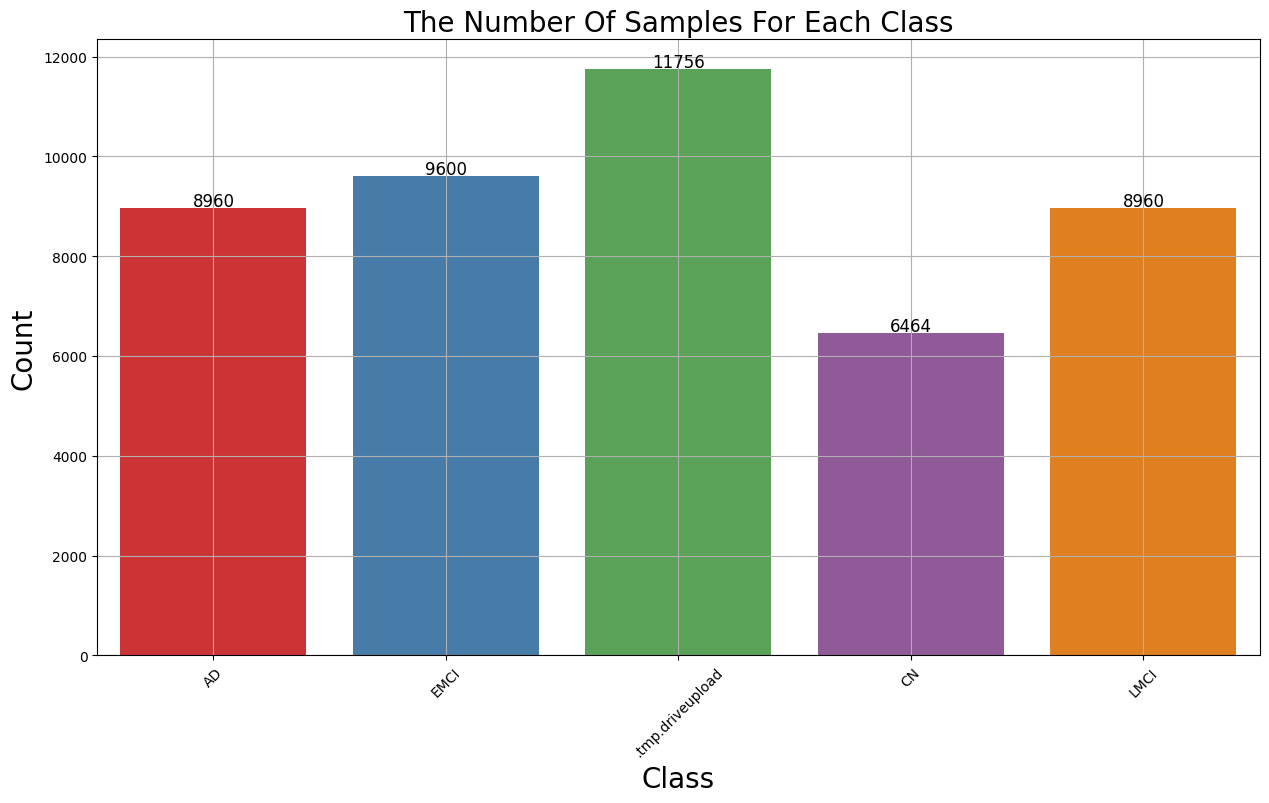

In [4]:
# Assuming `df` is your DataFrame and `label` is the column with class labels
class_counts = df['label'].value_counts()

# Print exact counts
print("Exact counts for each class:")
print(class_counts)

# Plot the class distribution
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=df['label'], palette='Set1')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class', fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)

# Annotate each bar with the exact count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


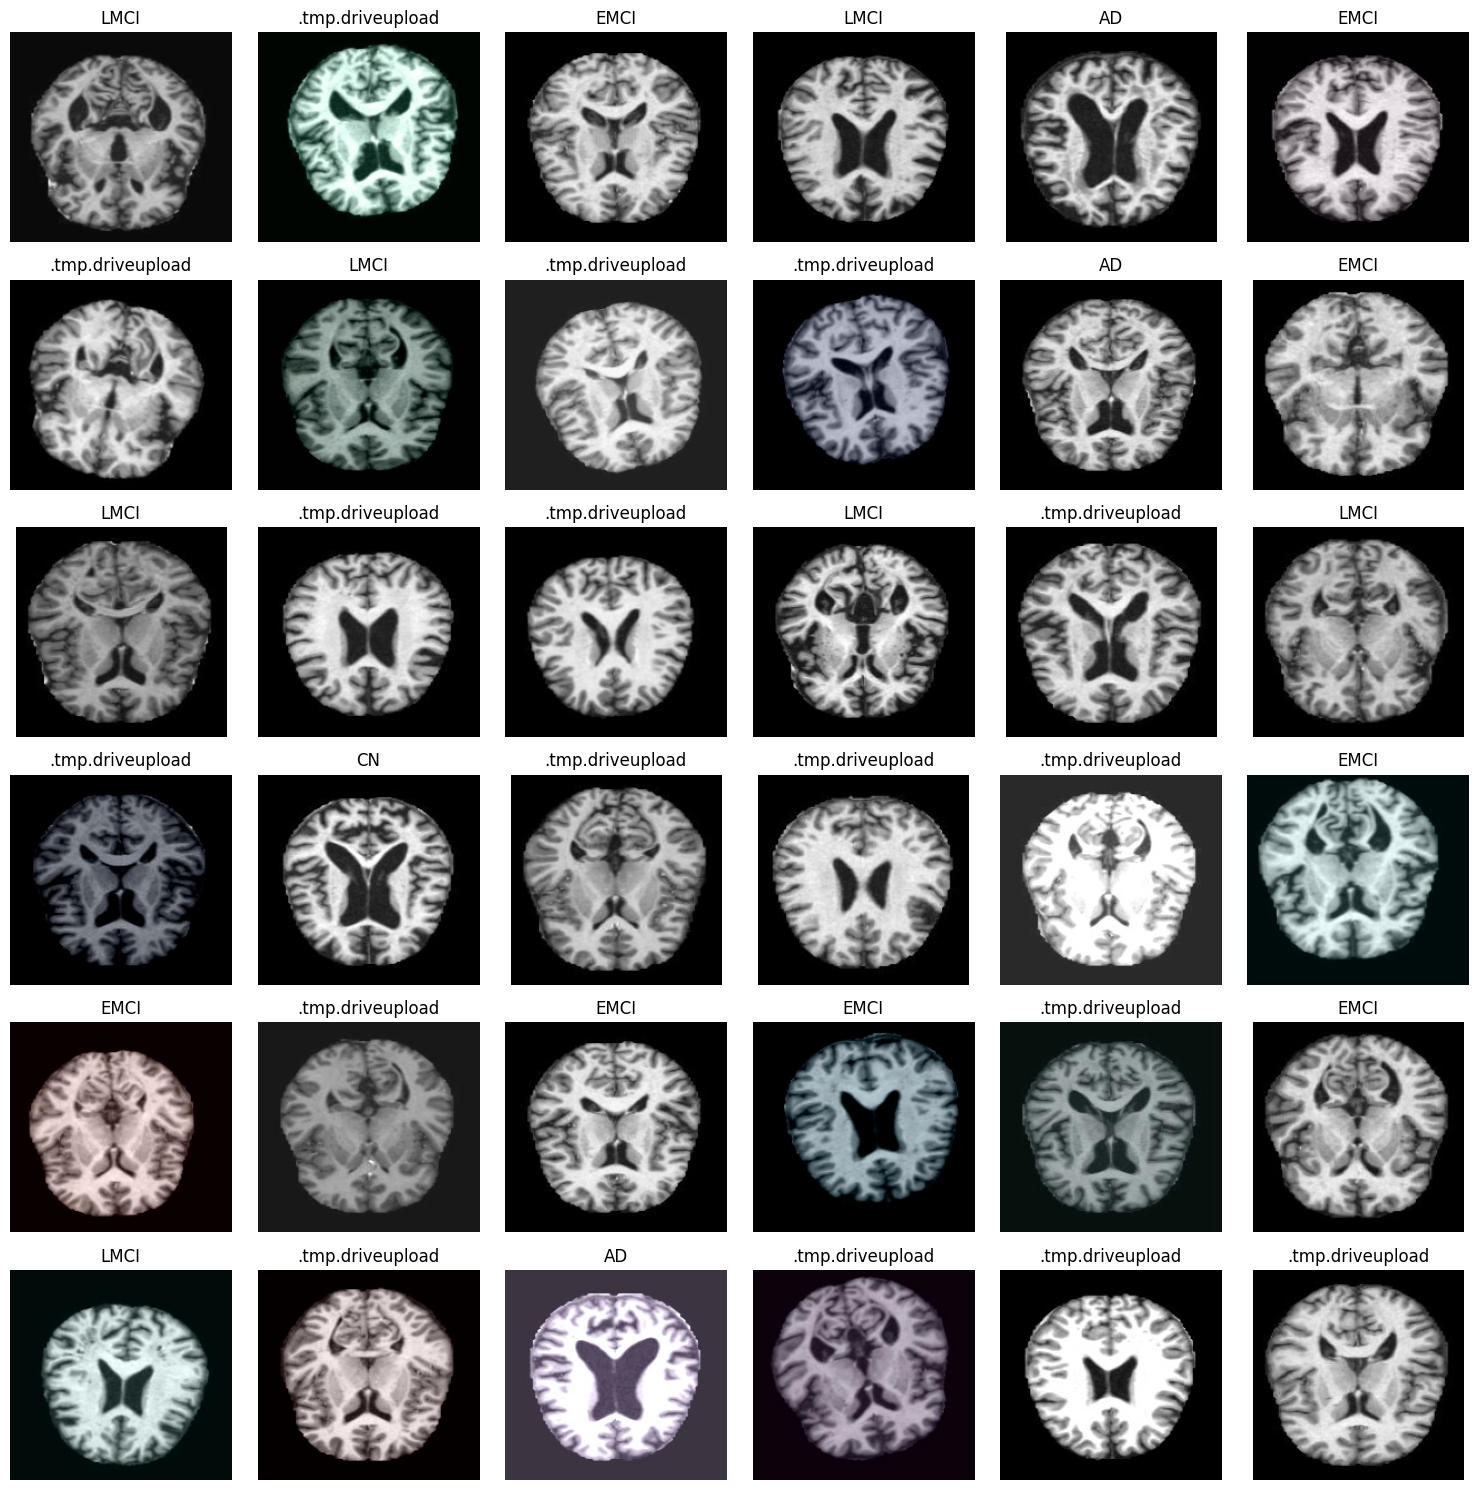

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

sample_df = df.sample(36).reset_index(drop=True)

plt.figure(figsize=(15, 15))

for i in range(36):
    plt.subplot(6, 6, i + 1)
    img = mpimg.imread(sample_df['image'][i])
    plt.imshow(img)
    plt.title(sample_df['label'][i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [7]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    color_mode='rgb',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 27187 validated image filenames belonging to 4 classes.
Found 3398 validated image filenames belonging to 4 classes.
Found 3399 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 9405 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1176 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1175 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [8]:
class_num=list(train_generator.class_indices.keys())
class_num

['AD', 'CN', 'EMCI', 'LMCI']

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,764,900 (29.62 MB)

 Trainable params: 7,762,212 (29.61 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [ ]:
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping_cb])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 14/850 ━━━━━━━━━━━━━━━━━━━━ 3:21:08 14s/step - accuracy: 0.2398 - loss: 2.4170

In [ ]:
model.save('/kaggle/working/model_Cnn2.keras')
model.export('/kaggle/working/model_Cnn2')

In [ ]:
loss,accuracy=model.evaluate(test_generator)
print("loss : ",loss)
print("accuracy : ",accuracy)

In [ ]:
ef=pd.DataFrame(history.history)
ef[['loss','val_loss']].plot()
ef[['accuracy','val_accuracy']].plot()

In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

In [ ]:
df

In [ ]:
correct_predictions = (y_test == y_pred).sum()
incorrect_predictions = (y_test != y_pred).sum()

labels = ['Correct', 'Incorrect']
sizes = [correct_predictions, incorrect_predictions]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Correct vs Incorrect Prediction')
plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

In [ ]:
plt.figure(figsize=(30,70))
batch = next(test_generator)
images= batch[0]
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test[n]]}, \n Predicted: {class_num[y_pred[n]]}.\n Confidence: {round(predictions[n][np.argmax(predictions[n])],0)}%",fontsize=20)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/model_Cnn2.keras')

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, class_num, target_size=(224, 224)):
    """
    Predicts the class of a single image and displays it with the prediction and confidence.

    Args:
        model: Trained Keras model.
        image_path (str): Path to the image file.
        class_num (dict): Dictionary mapping class indices to class labels.
        target_size (tuple): Target size for resizing the image.
    """
    # Load and preprocess the image
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image)  # Convert to numpy array
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize

    # Predict
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_num[predicted_class_index]
    confidence = round(np.max(predictions) * 100, 2)

    # Display the image and prediction
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class_label}\nConfidence: {confidence}%", fontsize=16)
    plt.show()

# Example Usage
image_path = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images/VeryMildDemented/0073c8fe-469d-4160-9344-37d61ac6f9bd.jpg"
class_num = {0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}
predict_single_image(model, image_path, class_num)
